In [1]:
import pandas as pd
import numpy as np
import scipy.integrate as integ


import matplotlib.pyplot as plt
import time



# Ejecuta esta celda para introducir los datos
datostld100 = 'datos/datostld100.xlsx'
DatosEntrada = pd.read_excel(
    datostld100, sheet_name='Hoja1', header=0, usecols=None, nrows=None)

dfnew = DatosEntrada


def leer_datos(dfnew):

    E = dfnew.iloc[:, 0].to_numpy()         # Energia de Activación (eV).
    s = dfnew.iloc[:, 1].to_numpy()          # Factor de Frecuencia (s-1).
    # Concentracion de electrones atrapados en las trampas (cm-3).
    n = dfnew.iloc[:, 2].to_numpy()
    # Numero de posiciones acesibles por los electrnes de la BC a la Trampa (cm-3).
    N = dfnew.iloc[:, 3].to_numpy()
    # Numero de posiciones acesibles por los electrones alcanzada la saturación (cm-3).
    Nsat = dfnew.iloc[:, 4].to_numpy()
    # Coeficiente de Probabilidad de atrapamiento de electrones de a trampa (cm+3·s-1).
    A = dfnew.iloc[:, 5].to_numpy()
    # Coeficiente de probabilidad de recombinacion e-h Radiativa (cm+3·s-1).
    Amn_R = dfnew.iloc[0:1, 6].to_numpy()
    # Coeficiente de probabilidad de recombinacion e-h No Radiativa (cm+3·s-1).
    Amn_NR = dfnew.iloc[0:1, 7].to_numpy()
    # Coeficiente de Probabilidad de atrapamiento de huecos de la BV al Centro de Recombinacion Radiativo (cm+3·s-1).
    A_R = dfnew.iloc[0:1, 8].to_numpy()
    # Coeficiente de Probabilidad de atrapamiento de huecos de la BV al Centro de Recombinacion No Radiativo (cm+3·s-1).
    A_NR = dfnew.iloc[0:1, 9].to_numpy()
    # Numero de posiciones acesibles huecos de la BV al Centro de Recombinacion Radiativo (cm-3).
    M_R = dfnew.iloc[0:1, 10].to_numpy()
    # Numero de posiciones acesibles huecos de la BV al Centro de Recombinacion No Radiativo (cm-3).
    M_NR = dfnew.iloc[0:1, 11].to_numpy()
    # Concentracion de h atrapados en el centro de recombonacion radiativo (cm-3).
    m_R = dfnew.iloc[0:1, 12].to_numpy()
    # Concentracion de h atrapados en el centro de recombonacion no radiativo (cm-3).
    M_NR = dfnew.iloc[0:1, 13].to_numpy()
    # Factor de generacion de pares e-h (cm-3·s-1).
    f = dfnew.iloc[0:1, 14].to_numpy()
    # Concentración de electrones libres en la banda de conduccion (cm-3).
    n_c = dfnew.iloc[0:1, 15].to_numpy()
    # Concentración de huecos libres en la banda de Valencia (cm-3).
    n_h = dfnew.iloc[0:1, 16].to_numpy()
    # Nivel de Fermi (Ev)
    Ef = dfnew.iloc[0:1, 17]
    Ef = float(Ef)

    return E, s, n, N, Nsat, A, Amn_R, Amn_NR, A_R, A_NR, M_R, m_R, M_NR, f, n_c, n_h, Ef


# Condiciones iniciales

E, s, n, N, Nsat, A, Amn_R, Amn_NR, A_R, A_NR, M_R, m_R, M_NR, f, n_c, n_h, Ef = leer_datos(
    dfnew)


nn = np.array(n_c[0])
for i in range(len(n)):
    nn = np.append(nn, n[i])
nn = np.append(nn, m_R[0])
nn = np.append(nn, M_NR[0])
nn = np.append(nn, n_h[0])

# Constante de boltzman
kb = 0.00008617333262


# Ejecuta esta celda para definir las funciones del modelo

# aquí definimos el N de saturación y corregimos el numero de trampas en 4 a parte de definir las funciones de N
# aquí definimos el N de saturación y corregimos el numero de trampas en 4 a parte de definir las funciones de N
Nsat = np.ones(len(N))*10**11
# N[3]=N[3]/2
# N[4]=3*N[4]/4
if len(N) == 5:
    Nsat[0] = Nsat[0]*25
    Nsat[1] = Nsat[1]*10
    Nsat[2] = Nsat[2]*5
    Nsat[3] = Nsat[3]*5
    Nsat[4] = Nsat[4]*65


def Ng(t, i):  # En esta función simulamos la creación de trampas durante la irradiación
    C = 1
    return N[i] * np.exp(np.log10(Nsat[i] / N[i]) * (1 - np.exp(-C * t)))


def Nee(E, i, T):  # Esta es la distribución de Fermi-Dirac que utilizaremos en la irradiación
    return N[i] / (1 + np.exp((E - Ef) / (kb * T)))


def NFCT(E, i, T, t):  # Aquí simulamos la creación de trampas durante la irradiación, utilizando también la distribución de Fermi-Dirac
    return Nee(E, i, T) * Ng(t, i) / N[i]


NN = N


def Ne(E, i, T):  # Aquí definimos la distribución de Fermi-Dirac
    # para utilizarla utilizando el numero de trampas disponibles tras la irradiación
    return NN[i] / (1 + np.exp((E - 2.7) / (kb * T)))


Tamb = 273.15


def TLIN(t, u):  # Con esta función simulamos la irradiación añadiendo la creación de trampas,
    # utilizando la función de arrenius para la probabilidad
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx) - 3):
        dx[i] = -u[i] * (s[i - 1] * np.exp(-E[i - 1] / (kb * Tamb))
                         ) + A[i - 1] * (Ng(t, i - 1) - u[i]) * u[0]
        Constante_A += dx[i]
    dx[0] = f - Constante_A - u[0] * (u[-3] * Amn_R[0] + u[-2] * Amn_NR[0])
    dx[-3] = A_R[0] * (M_R[0] - u[-3]) * u[-1] - u[0] * (u[-3] * Amn_R[0])
    dx[-2] = A_NR[0] * (M_NR[0] - u[-2]) * u[-1] - u[0] * (u[-2] * Amn_NR[0])
    dx[-1] = f - u[-1] * (+A_R[0] * (M_R[0] - u[-3]) +
                          A_NR[0] * (M_NR[0] - u[-2]))
    return np.array(dx, dtype=object)


def TLINE(t, u):  # Aquí simulamos la irradiación añadiendo la creación de trampas, utilizando la distribución de F-D
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx) - 3):
        dx[i] = -u[i] * (s[i - 1] * np.exp(-E[i - 1] / (kb * Tamb))) + \
            A[i - 1] * (NFCT(E[i - 1], i - 1, Tamb, t) - u[i]) * u[0]
        Constante_A += dx[i]
    dx[0] = f - Constante_A - u[0] * (u[-3] * Amn_R[0] + u[-2] * Amn_NR[0])
    dx[-3] = A_R[0] * (M_R[0] - u[-3]) * u[-1] - u[0] * (u[-3] * Amn_R[0])
    dx[-2] = A_NR[0] * (M_NR[0] - u[-2]) * u[-1] - u[0] * (u[-2] * Amn_NR[0])
    dx[-1] = f - u[-1] * (+A_R[0] * (M_R[0] - u[-3]) +
                          A_NR[0] * (M_NR[0] - u[-2]))
    return np.array(dx, dtype=object)


def TLRNE(t, u):  # Simulamos la relajación tras la irradiación (reduciendo la fuente de radiación en un factor 1000) partiendo de las concentraciones y
    # el número de trampas tras la irradiación añadiendo la creación de trampas, utilizando la distribución de F-D  Nota: revisar que esté bien implementado
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx) - 3):
        dx[i] = -u[i] * (s[i - 1] * np.exp(-E[i - 1] / (kb * Tamb))
                         ) + A[i - 1] * (NN[i - 1] - u[i]) * u[0]
        Constante_A += dx[i]
    dx[0] = f / 1000 - Constante_A - u[0] * \
        (u[-3] * Amn_R[0] + u[-2] * Amn_NR[0])
    dx[-3] = A_R[0] * (M_R[0] - u[-3]) * u[-1] - u[0] * (u[-3] * Amn_R[0])
    dx[-2] = A_NR[0] * (M_NR[0] - u[-2]) * u[-1] - u[0] * (u[-2] * Amn_NR[0])
    dx[-1] = f / 1000 - u[-1] * \
        (+A_R[0] * (M_R[0] - u[-3]) + A_NR[0] * (M_NR[0] - u[-2]))
    return np.array(dx, dtype=object)


def TLI(t, u):  # Simulación de la irradiación sin tener en cuenta la creación de trampas usando la ley de arrenius
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx)-3):
        dx[i] = -u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb))) + \
            A[i-1]*(N[i-1]-u[i])*u[0]
        Constante_A += dx[i]
    dx[0] = f-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
    dx[-3] = A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
    dx[-2] = A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
    dx[-1] = f-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
    return np.array(dx, dtype=object)


def TLR(t, u):  # Simulación de la relajación de la función anterior
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx)-3):
        dx[i] = -u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb))) + \
            A[i-1]*(N[i-1]-u[i])*u[0]
        Constante_A += dx[i]
    dx[0] = f/1000-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
    dx[-3] = A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
    dx[-2] = A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
    dx[-1] = f/1000-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
    return np.array(dx, dtype=object)


def TLE(t, u):  # Simulación del calentamiento
    Tamb = 297.15 + float(t) * beta
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx) - 3):
        if u[i] > 10:
            dx[i] = -u[i] * (s[i - 1] * np.exp(-E[i - 1] / (kb * Tamb))
                             ) + A[i - 1] * (NN[i - 1] - u[i]) * u[0]
            Constante_A += dx[i]
    dx[0] = f / 1000 - Constante_A - u[0] * \
        (u[-3] * Amn_R[0] + u[-2] * Amn_NR[0])
    dx[-3] = A_R[0] * (M_R[0] - u[-3]) * u[-1] - u[0] * (u[-3] * Amn_R[0])
    dx[-2] = A_NR[0] * (M_NR[0] - u[-2]) * u[-1] - u[0] * (u[-2] * Amn_NR[0])
    dx[-1] = f / 1000 - u[-1] * \
        (+A_R[0] * (M_R[0] - u[-3]) + A_NR[0] * (M_NR[0] - u[-2]))
    return np.array(dx, dtype=object)


def CT(t):
    return 297.15 + float(t) * 10


def TLECT(t, u):  # Simulación del calentamiento utilizando una curva de temperaturas
    # a elección (CT(t))
    Tamb = CT(t)
    kb = 0.00008617333262
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx)-3):
        if u[i] > 10:
            dx[i] = -u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb))
                           )+A[i-1]*(NN[i-1]-u[i])*u[0]
            Constante_A += dx[i]
    dx[0] = f/1000-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
    dx[-3] = A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
    dx[-2] = A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
    dx[-1] = f/1000-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
    return np.array(dx, dtype=object)


def tl(X, T, beta):  # Calculamos la curva de termoluminiscencia
    Temp = np.zeros(len(T))
    TL = np.zeros(len(T))
    for i in range(len(T)):
        Temp[i] = T[i]*beta+297.15-273.15
        TL[i] = A_R*X[0, i]*X[-3, i]/beta
    return Temp, TL


def tl200(X, T, beta):  # Guardamos 200 canales de la curva de termoluminiscencia
    Temp, TL = tl(X, T, beta)
    ti200 = np.linspace(T[0], T[-1], 200)
    t200 = np.linspace(Temp[0], Temp[-1], 200)
    tl200 = np.interp(t200, Temp, TL)
    return t200, tl200, ti200


def g200(X, T):
    x = np.zeros((200, len(X[0])), dtype=X.dtype)
    t = np.linspace(T[0], T[-1], 200)
    for i in range(len(X[1])):
        x[:, i] = np.interp(t, T, X[:, i])
    return (x, t)


# Iniziamos la variable que albergará el nuevo número de trampas
NN = np.zeros(len(N))


In [2]:
import scienceplots

plt.style.use('science')

Irradiación finalizada
Calentamiento finalizado
Irradiación finalizada
Calentamiento finalizado
Irradiación finalizada
Calentamiento finalizado


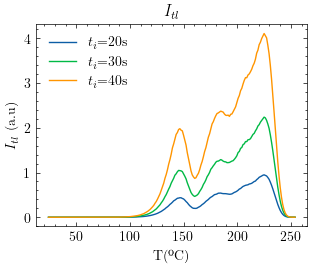

In [11]:
# Irradiación y relajación:
Tmax = [20,30,40]
TTt = np.linspace(0,240,200)
for tmax in Tmax:
    tmaxr = 20
    pasos = 100
    # tmax=20                 #tiempo de irradiación
    solirad = integ.RK45(fun=TLINE, t0=0, y0=nn, t_bound=tmax, max_step=np.inf,
                            rtol=0.01, atol=0.01, vectorized=False, first_step=None)

    for i in range(len(N)):
        # aquí estamos actualizando el numero de trampas que hay después de crearse para que lo use el resto de funciones
        NN[i] = NFCT(E[i], i, 297.15, tmax)
    ti = []
    xi = []  # Iniziamos la variable que

    for i in range(100):

        for i in range(1000):
            # get solution step state
            if solirad.status == 'finished':
                break
            solirad.step()
            ti.append(solirad.t)
            xi.append(solirad.y)
            # break loop after modeling is finished
            if solirad.status == 'finished':
                break
        xtemp, ttemp = g200(np.array(xi), ti)
    print('Irradiación finalizada')

    solrel = integ.RK45(fun=TLRNE, t0=0, y0=xi[-1], t_bound=tmaxr, max_step=np.inf,
                        rtol=0.01, atol=0.01, vectorized=False, first_step=None)
    tr = []
    xr = []  # Iniziamos la variable que

    for i in range(pasos):
        for i in range(1000):
            if solrel.status == 'finished':
                break
            # get solution step state
            solrel.step()
            tr.append(solrel.t)
            xr.append(solrel.y)
            # break loop after modeling is finished
            if solrel.status == 'finished':
                break
        xtempr = np.array(xr)

        # Representamos la concentración en las trampas en la relajación
    xi = np.array(xi)
    xr = np.array(xr)

    # calentamiento
    for i in range(len(N)):
        # aquí estamos actualizando el numero de trampas que hay después de crearse para que lo use el resto de funciones
        NN[i] = NFCT(E[i], i, 297.15, 230+273.15)

    CC = xr[-1]

    beta = 10
    # aquí definimos la temperatura máxima que queremos alcanzar en grados kelvin
    mt = ((230+273.15)-Tamb)/beta

    solcal = integ.RK45(fun=TLE, t0=0, y0=CC, t_bound=mt, max_step=np.inf,
                        rtol=0.01, atol=0.01, vectorized=False, first_step=None)
    tc = []
    xc = []  # Iniziamos la variable que
    TT = []

    for j in range(100):
        for i in range(3000):
            # get solution step state
            if solcal.status == 'finished':
                break
            solcal.step()
            tc.append(solcal.t)
            TT.append(solcal.t*beta+Tamb-273.15)
            xc.append(solcal.y)
            # break loop after modeling is finished
            if solcal.status == 'finished':
                break
    xtemp = np.array(xc)
    ttemp = np.array(tc)
    xg, tg = g200(xtemp, TT)
    # Representamos la concentración en las trampas en la relajación
    temp, tlc, ti200 = tl200(xtemp.T, tc, beta)
    print('Calentamiento finalizado')
    plt.plot(temp, tlc ,label=r'$t_i$='+str(tmax)+'s')

plt.legend()
plt.title(r'$I_{tl}$')
plt.xlabel('T(ºC)')
plt.ylabel(r'$I_{tl}$ (a.u)')
plt.show()   

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


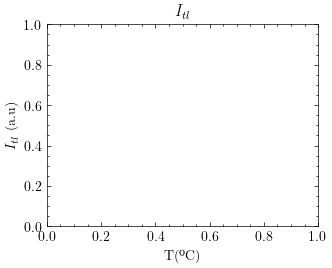

In [10]:
plt.legend()
plt.title(r'$I_{tl}$')
plt.xlabel('T(ºC)')
plt.ylabel(r'$I_{tl}$ (a.u)')
plt.show()   